In [146]:
# libraries
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [170]:
# Function to fetch and process crypto data
def fetch_and_process_crypto_data(coin='bitcoin', days=365, api_key="CG-JDG6gBA32v3WUqWnhPUT7ZLC"):
    # API request
    url = f"https://api.coingecko.com/api/v3/coins/{coin}/market_chart"
    params = {'vs_currency': 'usd', 'days': days}
    headers = {'Authorization': f'Bearer {api_key}'}
    response = requests.get(url, params=params, headers=headers)

    # Check for errors
    if response.status_code != 200:
        print(f"Error: {response.status_code} - {response.text}")
        return None

    # Convert API response to DataFrame
    data = response.json()
    df = pd.DataFrame(data['prices'], columns=['timestamp', 'price']).merge(
        pd.DataFrame(data['total_volumes'], columns=['timestamp', 'volume']), on='timestamp'
    )
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms')

    # Feature engineering
    df['ma7'] = df['price'].rolling(window=7).mean()
    df['ma30'] = df['price'].rolling(window=30).mean()
    df['volatility'] = df['price'].rolling(window=7).std()
    df['price_change'] = df['price'].pct_change()

    # Drop rows with NaN values
    return df.dropna()

# Fetch and process the data
crypto_data = fetch_and_process_crypto_data()
if crypto_data is not None:
    print(crypto_data.head())

        timestamp         price        volume       date           ma7  \
29  1705363200000  42587.336038  2.263453e+10 2024-01-16  44169.041107   
30  1705449600000  43148.001643  2.202312e+10 2024-01-17  43746.477616   
31  1705536000000  42713.859187  2.129906e+10 2024-01-18  43186.698479   
32  1705622400000  41261.394798  2.516043e+10 2024-01-19  42464.846944   
33  1705708800000  41600.940933  2.440787e+10 2024-01-20  42280.134277   

            ma30   volatility  price_change  
29  43585.018759  2077.707762      0.018813  
30  43642.924826  1912.337953      0.013165  
31  43643.914047  1442.625153     -0.010062  
32  43610.953667   678.733145     -0.034005  
33  43543.180893   717.340269      0.008229  


In [163]:
# Reverse normalization for predictions
predicted_prices = scaler.inverse_transform(
    np.hstack([predictions, np.zeros((predictions.shape[0], 3))])
)[:, 0]  # Extract only the 'price' column

# Reverse normalization for actual prices
actual_prices = scaler.inverse_transform(
    np.hstack([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 3))])
)[:, 0]

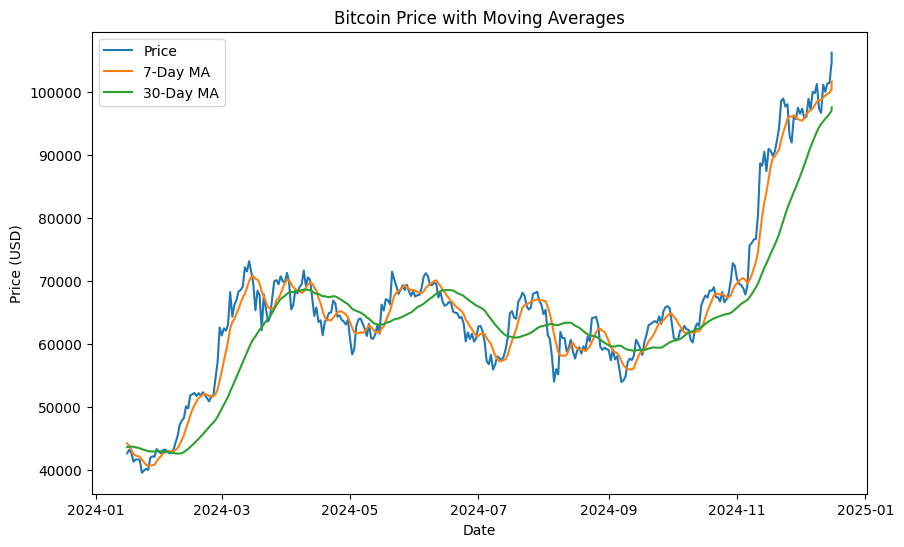

In [171]:
plt.figure(figsize=(10, 6))
plt.plot(crypto_data['date'], crypto_data['price'], label='Price')
plt.plot(crypto_data['date'], crypto_data['ma7'], label='7-Day MA')
plt.plot(crypto_data['date'], crypto_data['ma30'], label='30-Day MA')
plt.title('Bitcoin Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [172]:
# check for missing or unexpected values
print(crypto_data.info())
print(crypto_data.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 337 entries, 29 to 365
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     337 non-null    int64         
 1   price         337 non-null    float64       
 2   volume        337 non-null    float64       
 3   date          337 non-null    datetime64[ns]
 4   ma7           337 non-null    float64       
 5   ma30          337 non-null    float64       
 6   volatility    337 non-null    float64       
 7   price_change  337 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 23.7 KB
None
          timestamp          price        volume  \
count  3.370000e+02     337.000000  3.370000e+02   
mean   1.719878e+12   65500.647620  3.800174e+10   
min    1.705363e+12   39504.730058  6.340607e+09   
25%    1.712621e+12   59351.579491  2.135971e+10   
50%    1.719878e+12   64265.816313  3.143091e+10   
75%    1.7271

In [173]:
# normalizing data for LSTM
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(crypto_data[['price', 'volume', 'ma7', 'ma30']])

print("Scaled Data Example: ")
print(scaled_data[:5])

Scaled Data Example: 
[[0.04621565 0.08849635 0.05854685 0.01897244]
 [0.05462137 0.08517562 0.05162365 0.02002573]
 [0.04811254 0.08124312 0.04245233 0.02004372]
 [0.02633661 0.10221517 0.03062565 0.01944418]
 [0.03142722 0.09812784 0.02759935 0.01821142]]


First 5 rows of scaled data:
[[0.04621565 0.08849635 0.05854685 0.01897244]
 [0.05462137 0.08517562 0.05162365 0.02002573]
 [0.04811254 0.08124312 0.04245233 0.02004372]
 [0.02633661 0.10221517 0.03062565 0.01944418]
 [0.03142722 0.09812784 0.02759935 0.01821142]]


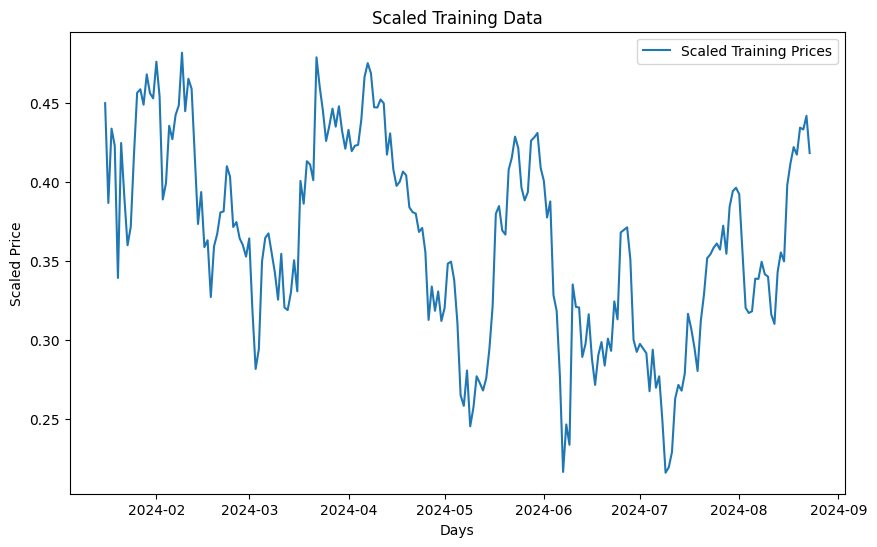

In [174]:
# Inspect scaled data
print("First 5 rows of scaled data:")
print(scaled_data[:5])

# Visualize price trends in the training data
plt.figure(figsize=(10, 6))
plt.plot(crypto_data['date'][:len(y_train)], y_train, label="Scaled Training Prices")
plt.title("Scaled Training Data")
plt.xlabel("Days")
plt.ylabel("Scaled Price")
plt.legend()
plt.show()

In [175]:
# Confirm no data leakage between training and testing sets
train_end_date = crypto_data['date'].iloc[split + sequence_length - 1]  # End date of training data
test_start_date = crypto_data['date'].iloc[split + sequence_length]  # Start date of testing data
print(f"Training data ends on: {train_end_date}")
print(f"Testing data starts on: {test_start_date}")

Training data ends on: 2024-10-22 00:00:00
Testing data starts on: 2024-10-23 00:00:00


In [176]:
# generate sequences for LSTM
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])  # Last 60 days
        y.append(data[i, 0])           # Predict price
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_data, seq_length=sequence_length)

print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

Shape of X: (277, 60, 4), Shape of y: (277,)


In [177]:
# splitting data
split = int(len(X) * 0.8)  # 80% for training
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# print shapes to confirm
print(f"Training Data: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing Data: X_test: {X_test.shape}, y_test: {y_test.shape}")

Training Data: X_train: (221, 60, 4), y_train: (221,)
Testing Data: X_test: (56, 60, 4), y_test: (56,)


In [178]:
# define LSTM model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=10,           # Stop if val_loss doesn't improve for 3 consecutive epochs
    restore_best_weights=True  # Restore the best weights at the end
)

model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# train model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    shuffle=False  # Disable shuffling
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.1131 - val_loss: 0.0398
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0154 - val_loss: 0.0491
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0072 - val_loss: 0.0868
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0089 - val_loss: 0.0398
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0062 - val_loss: 0.0490
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0048 - val_loss: 0.0678
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0047 - val_loss: 0.0563
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0038 - val_loss: 0.0539
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0039 - val_loss: 0.0624
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0038 - val_loss: 0.0588
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0035 - val_loss: 0.0623


In [ ]:
# Save the model after training
model.save('models/lstm_model_good.keras')

/Users/nikhilshetty/repos/cryptoPredictor/venv/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


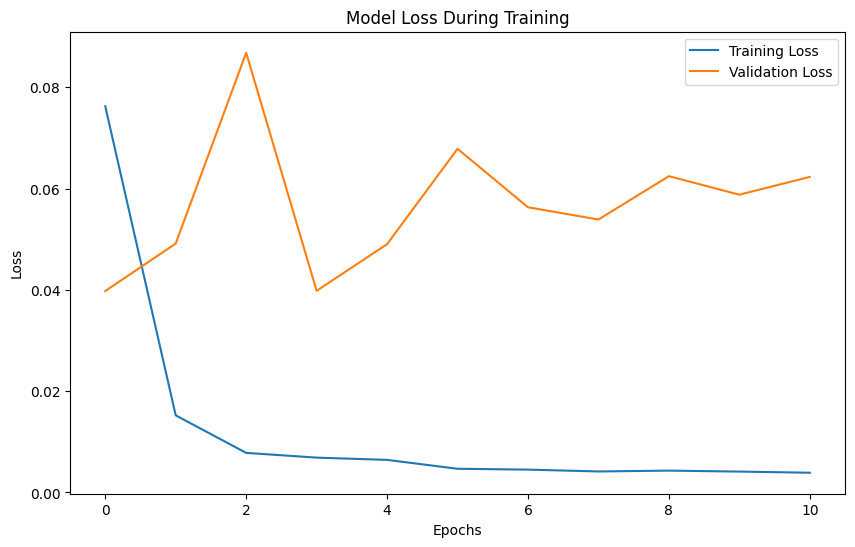

In [180]:
# visualize training for overfitting/underfitting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [95]:
# Reload the model
from tensorflow.keras.models import load_model
model = load_model('models/lstm_model_good.keras')

/Users/nikhilshetty/repos/cryptoPredictor/venv/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


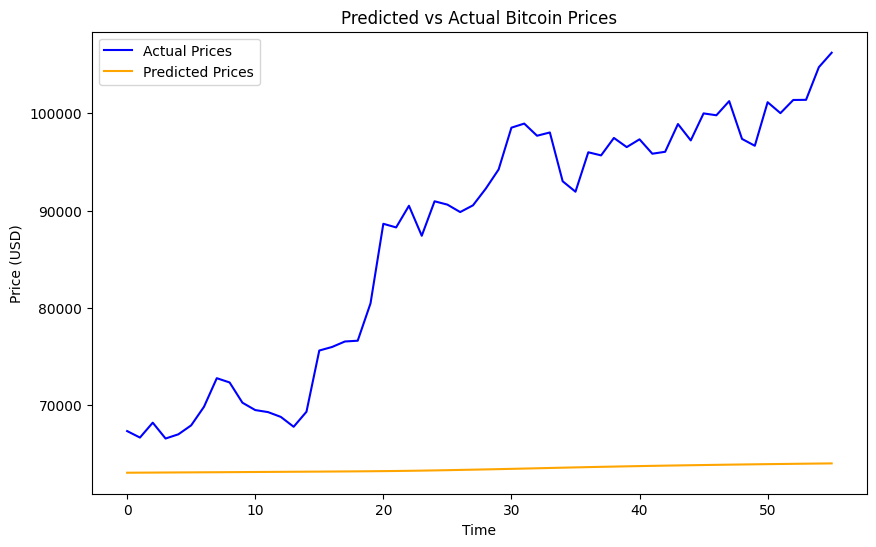

In [169]:
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label="Actual Prices", color='blue')
plt.plot(predicted_prices, label="Predicted Prices", color='orange')
plt.title("Predicted vs Actual Bitcoin Prices")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()